# **QAI_Master_Framework**

/tmp/ipython-input-1943301209.py:165: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(times_num, df["demand"], '-', label="Demand", linewidth=1)
/tmp/ipython-input-1943301209.py:166: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(times_num, df["served"], '-', label="Served Load", linewidth=1)


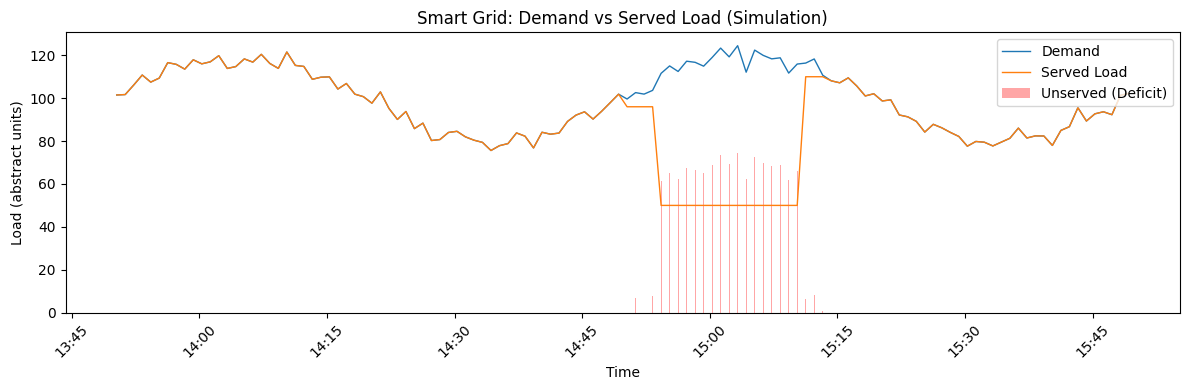

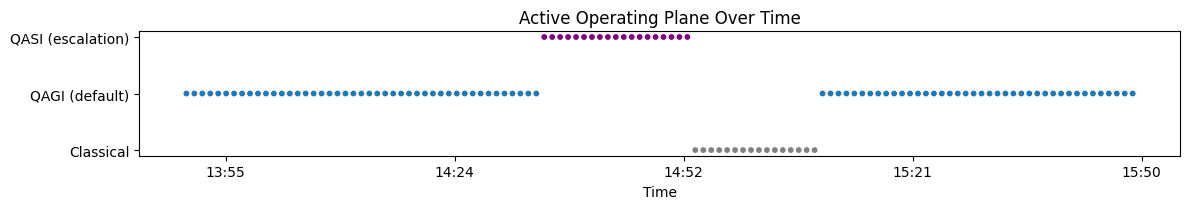

/tmp/ipython-input-1943301209.py:193: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(times_num, df["qagi_health"], '-', label="AGI Health", linewidth=1)
/tmp/ipython-input-1943301209.py:194: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(times_num, df["qpu_noise"], '-', label="QPU Noise", linewidth=1)


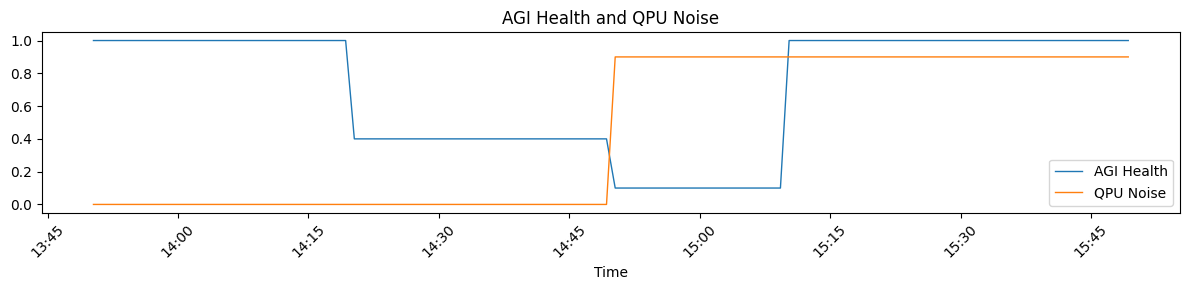

/tmp/ipython-input-1943301209.py:205: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(times_num, df["economic_cost"], '-', label="Estimated Operational Cost (relative)", linewidth=1)


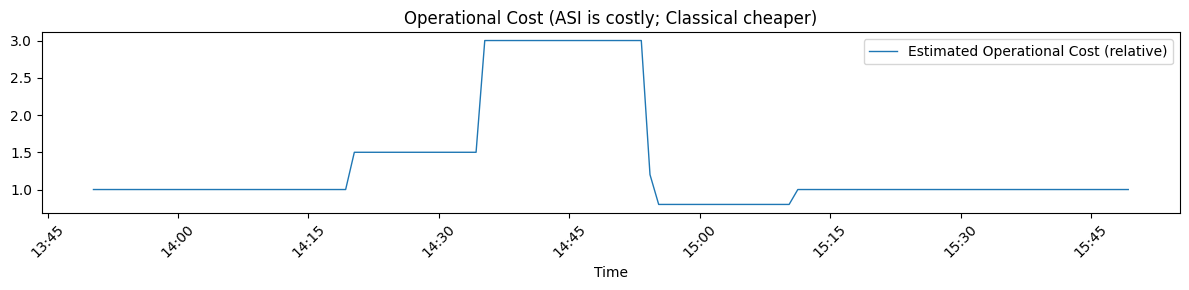


--- Events Timeline (sample) ---


,time,event
0,2025-10-06 14:20:17.014072,EVENT: AGI_DEGRADATION severity=0.6
1,2025-10-06 14:20:17.014072,Fallback to Classical partial: served=97.7 / d...
2,2025-10-06 14:21:17.014073,Fallback to Classical partial: served=102.9 / ...
3,2025-10-06 14:22:17.014075,Fallback to Classical partial: served=95.3 / d...
4,2025-10-06 14:23:17.014076,Fallback to Classical partial: served=90.1 / d...
5,2025-10-06 14:24:17.014077,Fallback to Classical partial: served=93.8 / d...
6,2025-10-06 14:25:17.014078,Fallback to Classical partial: served=85.8 / d...
7,2025-10-06 14:26:17.014080,Fallback to Classical partial: served=88.4 / d...
8,2025-10-06 14:27:17.014081,Fallback to Classical partial: served=80.3 / d...
9,2025-10-06 14:28:17.014082,Fallback to Classical partial: served=80.7 / d...



--- Summary Metrics ---


,total_demand,total_served,total_unserved,percent_unserved,asi_invocations,agi_degradations
0,11971.49914,10788.996967,1182.502173,9.877645,1,1



=== Simulation Summary ===
Total demand: 11971.5, Total served: 10789.0, Unserved: 1182.5 (9.88%)
ASI invocations: 1, AGI degradations: 1

=== Merit & Value to Client ===
Use case: Smart Grid Load Balancing
- QAGI is the default plane: handles routine optimizations and adaptive balancing.
- ASI is invoked for strategic reconfiguration when AGI cannot meet demand; ASI unlocks cross-region capacity at higher cost.
- Classical plane provides deterministic safety-critical control to avoid blackouts when advanced layers degrade.

Benefits:
1) Resilience: graceful degradation keeps critical services running.
2) Efficiency: AGI reduces operational cost in normal operation; ASI used sparingly for high-value remediation.
3) Safety & Auditability: snapshot/approval patterns and deterministic fallback support compliance.

Next steps (implementation):
- Replace simulated decision logic with live telemetry & CCH integration.
- Implement Instruction Mapper (QIM/IRX) and precompiled classical fallba

In [1]:
# Colab-ready demo: ASI / AGI / Classical escalation & fallback
# Use case: Smart Grid Load Balancing (simulation)
# Paste into one Colab cell and run.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from IPython.display import display, HTML

# -----------------------
# Initialization
# -----------------------
T = 120  # simulation steps (minutes)
time_index = [datetime.now() + timedelta(minutes=i) for i in range(T)]
np.random.seed(42)

# Demand signal (sinusoidal + noise)
base_load = 100 + 20 * np.sin(np.linspace(0, 4 * np.pi, T))
noise = np.random.normal(0, 3, T)
demand = base_load + noise

# Capacities (abstract units)
total_capacity = 160
classical_capacity = 80          # deterministic controllers
qagi_extra_capacity = 60        # AGI-added capacity (when healthy)
asi_extra_capacity = 40         # ASI strategic unlocked capacity

# Simulated health metrics
qagi_health = np.ones(T) * 1.0  # 1.0 = healthy
qpu_noise = np.zeros(T)
asi_authorized = True           # whether Gatekeeper allows ASI

# Planned anomaly events (indexes)
anomaly_events = {
    30: {"type": "AGI_DEGRADATION", "severity": 0.6},
    45: {"type": "GENERATOR_OUTAGE", "severity": 1.0},
    60: {"type": "QPU_FAILURE", "severity": 0.9},
    80: {"type": "AGI_RECOVERY", "severity": 0.0},
}

# State arrays
plane_active = ["QAGI"] * T
served_load = np.zeros(T)
unserved_load = np.zeros(T)
economic_cost = np.zeros(T)
events_log = []

# -----------------------
# Helper decision functions
# -----------------------
def agi_capacity(health):
    return qagi_extra_capacity * health

def asi_capacity_unlock():
    return asi_extra_capacity

def classical_response(demand_val, classical_cap):
    return min(classical_cap, demand_val)

def qagi_response(demand_val, health, classical_cap):
    cap = classical_cap + agi_capacity(health)
    return min(cap, demand_val)

def asi_response(demand_val, health, classical_cap):
    cap = classical_cap + agi_capacity(health) + asi_capacity_unlock()
    return min(cap, demand_val)

# -----------------------
# Simulation loop
# -----------------------
# Copy local variable to modify inside loop
classical_cap = classical_capacity

for t in range(T):
    d = float(demand[t])
    # handle scheduled anomalies
    if t in anomaly_events:
        ev = anomaly_events[t]
        events_log.append((time_index[t], f"EVENT: {ev['type']} severity={ev['severity']}"))
        if ev["type"] == "AGI_DEGRADATION":
            qagi_health[t:] = np.maximum(0.2, 1.0 - ev["severity"])
        if ev["type"] == "GENERATOR_OUTAGE":
            classical_cap = max(40, classical_cap - 30)
            events_log.append((time_index[t], "Classical capacity reduced due to outage."))
        if ev["type"] == "QPU_FAILURE":
            qpu_noise[t:] = ev["severity"]
            qagi_health[t:] = np.maximum(0.1, qagi_health[t:] - ev["severity"])
        if ev["type"] == "AGI_RECOVERY":
            qagi_health[t:] = 1.0
            events_log.append((time_index[t], "AGI recovered."))

    current_health = float(qagi_health[t])

    # Decision logic (simplified CCH + MEE behavior)
    if plane_active[t] == "QAGI":
        if current_health >= 0.6:
            alloc = qagi_response(d, current_health, classical_cap)
            served_load[t] = float(alloc)
            plane_active[t] = "QAGI"
            economic_cost[t] = 1.0 + 0.1 * (1 - current_health)
        else:
            potential_agi_alloc = qagi_response(d, current_health, classical_cap)
            # If AGI cannot meet demand and ASI is allowed, escalate
            if asi_authorized and d > potential_agi_alloc * 1.05:
                events_log.append((time_index[t], "CCH: Requesting ASI escalation."))
                plane_active[t] = "QASI"
                alloc = asi_response(d, current_health, classical_cap)
                served_load[t] = float(alloc)
                economic_cost[t] = 3.0
                events_log.append((time_index[t], "ASI invoked: strategic reconfiguration applied."))
            else:
                classical_alloc = classical_response(d, classical_cap)
                served = min(d, classical_alloc + potential_agi_alloc)
                served_load[t] = float(served)
                plane_active[t] = "CLASSICAL" if served < d else "QAGI"
                economic_cost[t] = 1.5
                events_log.append((time_index[t], f"Fallback to Classical partial: served={served:.1f} / demand={d:.1f}"))
    elif plane_active[t] == "QASI":
        alloc = asi_response(d, current_health, classical_cap)
        served_load[t] = float(alloc)
        economic_cost[t] = 3.0
        if alloc < d * 0.9:
            events_log.append((time_index[t], "ASI insufficient, forcing Classical fallback."))
            classical_alloc = classical_response(d, classical_cap)
            served_load[t] = float(classical_alloc)
            plane_active[t] = "CLASSICAL"
            economic_cost[t] = 1.2
    elif plane_active[t] == "CLASSICAL":
        alloc = classical_response(d, classical_cap)
        served_load[t] = float(alloc)
        economic_cost[t] = 0.8
        if current_health >= 0.9 and alloc < d:
            plane_active[t] = "QAGI"
            events_log.append((time_index[t], "AGI reactivation requested from Classical."))

    unserved_load[t] = max(0.0, d - served_load[t])
    if t + 1 < T:
        plane_active[t + 1] = plane_active[t]

# -----------------------
# Build results
# -----------------------
df = pd.DataFrame({
    "time": time_index,
    "demand": demand.astype(float),
    "served": served_load.astype(float),
    "unserved": unserved_load.astype(float),
    "active_plane": plane_active,
    "qagi_health": qagi_health.astype(float),
    "qpu_noise": qpu_noise.astype(float),
    "economic_cost": economic_cost.astype(float)
})

events_df = pd.DataFrame(events_log, columns=["time", "event"]).sort_values("time").reset_index(drop=True)

# -----------------------
# Visualizations
# -----------------------
times_num = mdates.date2num(df["time"])

# 1) Demand vs Served (with deficit bars)
plt.figure(figsize=(12,4))
plt.plot_date(times_num, df["demand"], '-', label="Demand", linewidth=1)
plt.plot_date(times_num, df["served"], '-', label="Served Load", linewidth=1)
deficit = np.maximum(0, df["demand"] - df["served"])
bar_width = (times_num.max() - times_num.min()) * 0.0008
plt.bar(times_num, deficit, width=bar_width, color='red', alpha=0.35, label="Unserved (Deficit)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("Smart Grid: Demand vs Served Load (Simulation)")
plt.xlabel("Time")
plt.ylabel("Load (abstract units)")
plt.legend(loc="upper right")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2) Active Plane Over Time
plt.figure(figsize=(12,2.2))
plane_colors = {"CLASSICAL": "gray", "QAGI": "tab:blue", "QASI": "purple"}
y = [1 if p == "QAGI" else (2 if p == "QASI" else 0) for p in df["active_plane"]]
plt.scatter(times_num, y, c=[plane_colors[p] for p in df["active_plane"]], s=10)
plt.yticks([0,1,2], ["Classical", "QAGI (default)", "QASI (escalation)"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("Active Operating Plane Over Time")
plt.xlabel("Time")
plt.tight_layout()
plt.show()

# 3) AGI Health and QPU Noise
plt.figure(figsize=(12,3))
plt.plot_date(times_num, df["qagi_health"], '-', label="AGI Health", linewidth=1)
plt.plot_date(times_num, df["qpu_noise"], '-', label="QPU Noise", linewidth=1)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("AGI Health and QPU Noise")
plt.xlabel("Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4) Operational cost (relative)
plt.figure(figsize=(12,3))
plt.plot_date(times_num, df["economic_cost"], '-', label="Estimated Operational Cost (relative)", linewidth=1)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("Operational Cost (ASI is costly; Classical cheaper)")
plt.xlabel("Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------
# Summary tables & metrics
# -----------------------
summary = {
    "total_demand": df["demand"].sum(),
    "total_served": df["served"].sum(),
    "total_unserved": df["unserved"].sum(),
    "percent_unserved": 100.0 * df["unserved"].sum() / df["demand"].sum(),
    "asi_invocations": sum(1 for e in events_log if "ASI invoked" in e[1]),
    "agi_degradations": sum(1 for e in events_log if "AGI" in e[1] and "degrad" in e[1].lower()),
}
summary_df = pd.DataFrame([summary])

print("\n--- Events Timeline (sample) ---")
display(events_df.head(20))  # show some events

print("\n--- Summary Metrics ---")
display(summary_df)

print("\n=== Simulation Summary ===")
print(f"Total demand: {summary['total_demand']:.1f}, Total served: {summary['total_served']:.1f}, Unserved: {summary['total_unserved']:.1f} ({summary['percent_unserved']:.2f}%)")
print(f"ASI invocations: {summary['asi_invocations']}, AGI degradations: {summary['agi_degradations']}")

print("\n=== Merit & Value to Client ===")
print("Use case: Smart Grid Load Balancing")
print("- QAGI is the default plane: handles routine optimizations and adaptive balancing.")
print("- ASI is invoked for strategic reconfiguration when AGI cannot meet demand; ASI unlocks cross-region capacity at higher cost.")
print("- Classical plane provides deterministic safety-critical control to avoid blackouts when advanced layers degrade.")
print("\nBenefits:")
print("1) Resilience: graceful degradation keeps critical services running.")
print("2) Efficiency: AGI reduces operational cost in normal operation; ASI used sparingly for high-value remediation.")
print("3) Safety & Auditability: snapshot/approval patterns and deterministic fallback support compliance.")

print("\nNext steps (implementation):")
print("- Replace simulated decision logic with live telemetry & CCH integration.")
print("- Implement Instruction Mapper (QIM/IRX) and precompiled classical fallbacks.")
print("- Integrate Gatekeeper multi-signer flows before enabling automatic ASI escalation in production.")


**Concept and execution by Bhadale IT, code generated by ChatGPT**